# MLB Players Hall Of Fame Prediction

 -- By Shuzhan Fan, Mar. 8 2019

## Import libraries and load data

First, import all necessary libraries:

In [47]:
# Analysis imports
import numpy as np
import pandas as pd

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Miscellaneous imports 
import warnings
warnings.filterwarnings("ignore")

Next, I'll load the data:

In [2]:
df_batting = pd.read_csv("./baseballdatabank-master/core/Batting.csv", header="infer")
df_master  = pd.read_csv("./baseballdatabank-master/core/Master.csv", header="infer")
df_hof     = pd.read_csv("./baseballdatabank-master/core/HallOfFame.csv", header="infer")

## Data cleaning

In [3]:
df_hof["category"].unique()

array(['Player', 'Manager', 'Pioneer/Executive', 'Umpire'], dtype=object)

In [4]:
# Remove all the rows who are not a Player in HallOfFame table
df_hof = df_hof[df_hof["category"] == "Player"]

In [5]:
# Show the first five rows in HallofFame table
df_hof.head()

,playerID,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN


According to the description of this exercise problem, I will be building a predictive model that predicts whether a batter will ultimately make it into the Hall of Fame, instead of whether a batter will make it into the Hall of Fame in a given voting year. Thus, in the HallOfFame table, I only care about those players who were inducted eventually.

In [6]:
# Keep the rows with "inducted" value of "Y"
df_hof = df_hof[df_hof["inducted"] == "Y"]
df_hof = df_hof[["playerID", "inducted"]]
df_hof = df_hof.rename(columns={"inducted": "halloffame"})

Since we should focus on only batters in this exercise, I'll simply remove the rows with an "AB" (i.e. at-bat) value of 0 or NaN, since a player has to at least attempt to hit in order to be considered as a batter.

In [7]:
print("There are %d rows in Batting table \nThere are %d rows with AB value of 0 \nThere are %d rows with AB value of NaN" % (len(df_batting), len(df_batting[df_batting["AB"] == 0]), df_batting["AB"].isnull().sum()))

There are 101332 rows in Batting table 
There are 9773 rows with AB value of 0 
There are 5149 rows with AB value of NaN


In [8]:
# Keep the rows with "AB" value larger than 0
df_batting = df_batting[df_batting["AB"] > 0]

In [9]:
df_batting.shape

(86410, 22)

## Feature engineering

### 1. Aggregation and Joining

The Batting table contains year by year batting statistics for each player. In order for the predictive model to work for each player, I need to aggregate the statistics across each player's professional career.

In [10]:
# Count the number of seasons played for each player
seasons = df_batting[["playerID", "yearID"]].groupby("playerID").count()
seasons = seasons.reset_index()
seasons = seasons.rename(columns={"yearID": "seasons"})

# Sum the career statistic for each player
batter_sum       = df_batting.groupby("playerID").sum()

# Calculate the batting average (BA) for each player
batter_sum["BA"] = batter_sum["H"] / batter_sum["AB"]

# Add the number of seasons to the career sum dataframe using left outer join
batter_sum       = batter_sum.merge(seasons, on="playerID", how="left")

# Remove the yearID column 
batter_sum.drop(["yearID"], axis=1, inplace=True)

In [11]:
df_hof.shape

(247, 2)

In [12]:
batter_sum.shape

(16704, 21)

In [13]:
batter_sum.head()

,playerID,stint,G,AB,R,H,2B,3B,HR,RBI,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,seasons
0,aardsda01,3,125,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.000000,3
1,aaronha01,23,3298,12364.0,2174.0,3771.0,624.0,98.0,755.0,2297.0,...,73.0,1402.0,1383.0,293.0,32.0,21.0,121.0,328.0,0.304998,23
2,aaronto01,7,437,944.0,102.0,216.0,42.0,6.0,13.0,94.0,...,8.0,86.0,145.0,3.0,0.0,9.0,6.0,36.0,0.228814,7
3,aasedo01,1,49,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
4,abadan01,3,15,21.0,1.0,2.0,0.0,0.0,0.0,0.0,...,1.0,4.0,5.0,0.0,0.0,0.0,0.0,1.0,0.095238,3


I then merge the batter_sum and df_hof using a left outer join:

In [14]:
# Left outer join batter_sum and df_hof
batter = batter_sum.merge(df_hof, on="playerID", how="left")

The matched players will have halloffame value of "Y", which means they are a member of HOF. All other non-matched players have halloffame value of NaN. I then converted all "Y" values to 1 and all NaN values to 0.

In [15]:
# Convert halloffame values to 0 or 1
batter["halloffame"] = batter["halloffame"].apply(lambda x: 1 if x=="Y" else 0)

In [16]:
# Check null values
batter.isnull().sum()

playerID      0
stint         0
G             0
AB            0
R             0
H             0
2B            0
3B            0
HR            0
RBI           0
SB            0
CS            0
BB            0
SO            0
IBB           0
HBP           0
SH            0
SF            0
GIDP          0
BA            0
seasons       0
halloffame    0
dtype: int64

The biographical information provided in Master table may also provide valuable insights into whether or not a player will make into the Hall Of Fame.

In [17]:
# Check first five rows of Master table
df_master.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,220.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


There are many features/columns in Master table. Instead of including all these features, I will only include several features which are likely to be related to whether or not the player will make into the Hall of Fame. Since this predictive model only predicts whether or not a player will ultimately make into the Hall of Fame, the birth and death ralated features may be excluded.

In [18]:
# Only include features "playerID", "birthCountry", "weight", "height", "bats"
df_master = df_master[["playerID", "birthCountry", "weight", "height", "bats"]]

# convert birthCountry value to either USA (1) or non-USA (0)
df_master["birthCountry"] = df_master["birthCountry"].apply(lambda x: 1 if x=="USA" else 0)

In [19]:
# Check null values
df_master.isnull().sum()

playerID           0
birthCountry       0
weight           871
height           805
bats            1191
dtype: int64

In [20]:
# Delete rows with null values
df_master = df_master.dropna(axis=0, how="any")

# Reset index
df_master = df_master.reset_index(drop=True)

In [21]:
# Check "bats" unique values 
df_master["bats"].unique()

array(['R', 'L', 'B'], dtype=object)

### 2. One-hot encoding

Now I'll **one-hot encode** the "bats" feature:

In [22]:
# One-hot encoding of a categorical feature
def onehot_encoding(column):
    '''
    Convert a categorical feature in a dataframe column to an one-hot encoding
    '''
    # LabelEncoder() encods categorical labels with integers
    labelencoder    = LabelEncoder() 
    integer_encoded = labelencoder.fit_transform(column) 
    # Scikit-learn expects the samples in form of a 2-D array
    integer_encoded = integer_encoded.reshape(-1,1) 
    # OneHotEncoder() encodes integer features with one-hot encodings
    onehotencoder   = OneHotEncoder()
    onehot_encoded  = onehotencoder.fit_transform(integer_encoded)
    # Convert sparse array to dense array, then convert to a list 
    onehot_encoded  = onehot_encoded.toarray().tolist()
    return onehot_encoded

# Convert a categorical feature to an one-hot encoding list
bats      = onehot_encoding(df_master["bats"])

# Create a dataframe
df_bats   = pd.DataFrame(bats, columns=["bats_B", "bats_L", "bats_R"])

# Add one-hot encoding dataframe back to the original dataframe
df_master = pd.concat([df_master, df_bats], axis=1)

# Drop the categorical feature
df_master = df_master.drop(["bats"], axis=1)

In [23]:
df_master.head()

,playerID,birthCountry,weight,height,bats_B,bats_L,bats_R
0,aardsda01,1,220.0,75.0,0.0,0.0,1.0
1,aaronha01,1,180.0,72.0,0.0,0.0,1.0
2,aaronto01,1,190.0,75.0,0.0,0.0,1.0
3,aasedo01,1,190.0,75.0,0.0,0.0,1.0
4,abadan01,1,184.0,73.0,0.0,1.0,0.0


Then merge the batter dataframe with df_master dataframe using left inner join:

In [24]:
# Inner join batter with df_master
batter_all = batter.merge(df_master, on="playerID", how="inner")

### 3. Normalization

The last step of feature enginnering is to **normalize/scale** the numerical features:

In [25]:
# Initialize the StandardScaler, which will scale each feature to a value with distribution of mean 0 and standard deviation 1
scaler = StandardScaler()

# Dataframe containing all numerical fatures to be scaled
X_scale = batter_all[['stint', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
          'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'BA', 'seasons', 'weight', 'height']]

# Fit scaler estimator and standardize the numerical features
X_scale = scaler.fit_transform(X_scale)

# Convert the scaled numpy array to a dataframe
df_X1 = pd.DataFrame(X_scale, columns=['stint', 'G', 'AB', 'R', 'H', '2B', '3B', 
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'BA', 'seasons', 'weight', 'height'])

# The dataframe containing the unscaled features
df_X2 = batter_all[["playerID", "birthCountry", "bats_B", "bats_L", "bats_R", "halloffame"]]

# Concatenate the scaled and unscaled features 
batter_all = pd.concat([df_X1, df_X2], axis=1)


In [26]:
# Show first five rows of batter_all
batter_all.head()

,stint,G,AB,R,H,2B,3B,HR,RBI,SB,...,BA,seasons,weight,height,playerID,birthCountry,bats_B,bats_L,bats_R,halloffame
0,-0.518733,-0.390219,-0.532705,-0.474499,-0.497809,-0.476128,-0.409405,-0.336489,-0.459537,-0.320778,...,-1.621311,-0.490633,1.653801,1.115813,aardsda01,1,0.0,0.0,1.0,0
1,3.123607,6.173369,6.637830,7.959255,7.264882,6.771606,4.352771,13.515928,9.098745,3.693020,...,0.956732,3.527670,-0.268513,-0.073828,aaronha01,1,0.0,0.0,1.0,1
2,0.209735,0.255176,0.012627,-0.078803,-0.053168,0.011700,-0.117844,-0.097971,-0.068384,-0.170261,...,0.312769,0.313028,0.212065,1.115813,aaronto01,1,0.0,0.0,1.0,0
3,-0.882967,-0.547431,-0.532125,-0.474499,-0.497809,-0.476128,-0.409405,-0.336489,-0.459537,-0.320778,...,-1.621311,-0.892463,0.212065,1.115813,aasedo01,1,0.0,0.0,1.0,0
4,-0.518733,-0.617762,-0.522842,-0.470619,-0.493692,-0.476128,-0.409405,-0.336489,-0.459537,-0.320778,...,-0.816297,-0.490633,-0.076282,0.322719,abadan01,1,0.0,1.0,0.0,0


In [27]:
# Calculate number of players who are not in HOF and who are in HOF
batter_all["halloffame"].value_counts()

0    15216
1      221
Name: halloffame, dtype: int64

As we can see, the majority of batters did not make into the Hall of Fame. This results in a **class imbalance probelm**.  

## Machine learning

### 1. Random forest classifier

To account for the class imbalance in the data, I will use a bagging (random forest classification) method and I will reweight the classes using the "class_weight" flag passed to the random forest classifier at initialization. 

I chose to use a random forest classifier as it tends to require short amount of time to optimize, reduces variance in comparison to regular decision trees, is able to handle non-linear relationships, and can provide feature importance measures for input variables. With more time, I would also explore other models, e.g., logistic regression, SVC, etc. 

In [75]:
X = batter_all.drop(["halloffame", "playerID"], axis=1)
y = batter_all["halloffame"]

# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=321)

# Setup 5-fold stratified cross validation
cv = StratifiedKFold(n_splits=5)

# Define a parameter grid to search over 
param_grid = {"max_features": ["sqrt", "log2", 10], "n_estimators": [50, 100, 150, 200], "max_depth": [3, 5, 7, 9]}

# Initialize a random forest classifier 
rfc = RandomForestClassifier(class_weight="balanced")

# Grid search different combinations of hyperparameters with 5-fold cv
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=3)

# Fit the estimator
rfc_grid.fit(X_train, y_train)

# Select the estimator with the best scoring 
rfc_best = rfc_grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.9min finished


Since the data is highly imbalanced, it's not appropriate to use accuracy as the metric to evaluate the predictive performance of the model. I'll calculate the area under ROC curve using only the testing data set. Also, I'll show the full classification report with precision, recall, and F-1 score.

	Classification Report for Random Forest Classifier

                precision    recall  f1-score   support

not-halloffame       0.99      0.98      0.99      4564
    halloffame       0.38      0.63      0.48        68

     micro avg       0.98      0.98      0.98      4632
     macro avg       0.69      0.81      0.73      4632
  weighted avg       0.99      0.98      0.98      4632


Area under ROC curve: 0.81


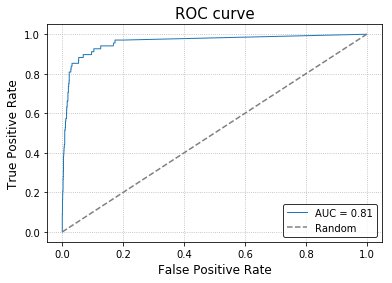

In [29]:
# Prediction results for testing set
y_pred = rfc_best.predict(X_test)

# Calculate AUC score and generate classification report
roc_score = roc_auc_score(y_test, y_pred)
print("\tClassification Report for Random Forest Classifier\n")
print(classification_report(y_test, y_pred, target_names=["not-halloffame", "halloffame"]))
print("\nArea under ROC curve: %0.2f" % roc_score)

# Plotting ROC curve 
y_prob = rfc_best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, lw=1, label="AUC = %0.2f" %(roc_score))
ax.plot([0, 1], [0, 1], '--', color=(0.5, 0.5, 0.5), label='Random')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC curve", fontsize=15)
ax.legend(loc="best", frameon = True).get_frame().set_edgecolor('black')
ax.grid(True, linestyle = 'dotted')

We can see from the classification report that the precision and recall for halloffame predictions are quite low compared to that for not-halloffame. This major imbalance makes me think that perhaps the class reweighting implemented at initialization of the random forest classifier didn't work so well.

So I decided to repeat the same ML pipeline but with the addition of performing a SMOTE upsampling of the data in an effort to address the rather low precision and recall associated with predicting halloffame.

### 2. Random forest classifier with SMOTE upsampling

In [30]:
# Apply SMOTE oversampling technique
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert resampled numpy array to dataframe 
X_res = pd.DataFrame(X_resampled, index=range(X_resampled.shape[0]), columns=X.columns)
y_res = pd.Series(y_resampled)

# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=321)

# Setup 5-fold stratified cross validation
cv = StratifiedKFold(n_splits=5)

# Define a parameter grid to search over 
param_grid = {"max_features": ["sqrt", "log2", 10], "n_estimators": [50, 100, 150, 200], "max_depth": [3, 5, 7, 9]}

# Initialize a random forest classifier 
rfc = RandomForestClassifier(class_weight="balanced")

# Grid search different combinations of hyperparameters with 5-fold cv
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=3)

# Fit the estimator
rfc_grid.fit(X_train, y_train)

# Select the estimator with the best scoring 
rfc_best = rfc_grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.3min finished


The same validation procedure is applied to check whether the upsampling helped at all.

	Classification Report for Random Forest Classifier

                precision    recall  f1-score   support

not-halloffame       1.00      0.98      0.99      4544
    halloffame       0.98      1.00      0.99      4586

     micro avg       0.99      0.99      0.99      9130
     macro avg       0.99      0.99      0.99      9130
  weighted avg       0.99      0.99      0.99      9130


Area under ROC curve: 0.99


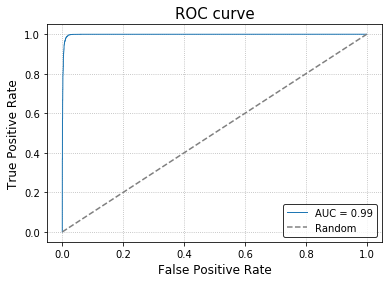

In [31]:
# Prediction results for testing set
y_pred = rfc_best.predict(X_test)

# Calculate AUC score
roc_score = roc_auc_score(y_test, y_pred)
print("\tClassification Report for Random Forest Classifier\n")
print(classification_report(y_test, y_pred, target_names=["not-halloffame", "halloffame"]))
print("\nArea under ROC curve: %0.2f" % roc_score)

# Plotting ROC curve 
y_prob = rfc_best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, lw=1, label="AUC = %0.2f" %(roc_score))
ax.plot([0, 1], [0, 1], '--', color=(0.5, 0.5, 0.5), label='Random')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC curve", fontsize=15)
ax.legend(loc="best", frameon = True).get_frame().set_edgecolor('black')
ax.grid(True, linestyle = 'dotted')

Validation results show that the upsampling definitely seemed to help. It's a little disconcerting that both precision and recall scores are alomost perfect. I'm cautious about possible overfitting effect. Given more time, I would look into this. But for now, I will move on.

I will then show the most important features based on the optimized random forest classifer.

### 3. Feature importances

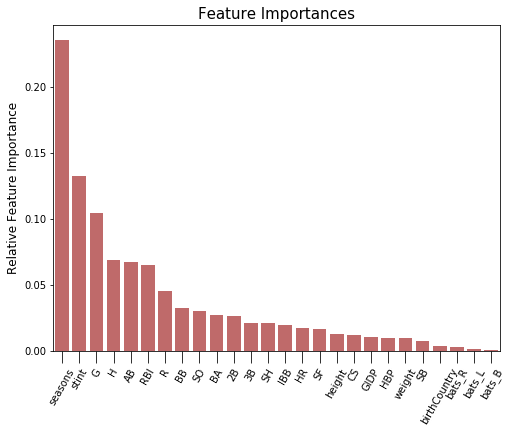

In [33]:
# Feature names
features = X.columns

# Feature importances
feature_importances = rfc_best.feature_importances_

# Indices of feature importances in a descending order
indices = np.argsort(feature_importances)[::-1]

# Plotting feature importances
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features[indices], y=feature_importances[indices], color="indianred")
ax.set_ylabel("Relative Feature Importance", fontsize=12)
ax.set_title("Feature Importances", fontsize=15)
ax.xaxis.set_tick_params(rotation=60, size=12)

As we can see from the feature importance plot, "seasons" is the most important feature. This makes sense as this feafure denotes how many seasons the player played in MLB. More seasons mean the player has more statistics to be collected and is more likely to break some types of records, and hence more likely to make into the Hall of Fame. Other important features such as "stint" (order of appearances within a season), "G" (number of games in which a player played), "AB" (at bats), etc. also make sense to be important predictors for the halloffame prediction. Another intersting thing to note is that it looks like the biographical features from the Master table are not that useful at predicting halloffame (the four least important features come from biographical features).


## Future work

* Perform feature selection or dimensionality reduction
* Do more feature engineering
* Try some other models
* Look into other class imbalance handling techniques